In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json
import os

## Data Loading

Load data from Question 1.B (flexible consumer with usage preferences)

In [9]:
# Define data folder path for Question 1.B
folder_path = '../data/question_1b'
file_type = ".json"

# Load all parameter files
with open(os.path.join(folder_path, f'appliance_params{file_type}'), 'r') as f:
    appliance_params = json.load(f)

with open(os.path.join(folder_path, f'bus_params{file_type}'), 'r') as f:
    bus_params = json.load(f)

with open(os.path.join(folder_path, f'consumer_params{file_type}'), 'r') as f:
    consumer_params = json.load(f)

with open(os.path.join(folder_path, f'DER_production{file_type}'), 'r') as f:
    DER_production = json.load(f)

with open(os.path.join(folder_path, f'usage_preferences{file_type}'), 'r') as f:
    usage_preference = json.load(f)

print("Data loaded successfully")

Data loaded successfully


In [10]:
# Extract system parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

# Extract PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile]

# Extract load parameters and reference profile
load_data = appliance_params['load'][0]
D_max = load_data['max_load_kWh_per_hour']
D_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio']
D_ref = [D_max * ratio for ratio in D_ref_ratio]

# Temporal parameters
T = len(electricity_prices)
Times = range(T)

# Discomfort penalty parameter
alpha = 0.5

print(f"Planning horizon: {T} hours")
print(f"Import tariff: {tau_imp} DKK/kWh")
print(f"Export tariff: {tau_exp} DKK/kWh")
print(f"PV capacity: {pv_max_power} kW")
print(f"Max load: {D_max} kW")
print(f"Discomfort penalty (α): {alpha}")

Planning horizon: 24 hours
Import tariff: 0.5 DKK/kWh
Export tariff: 0.4 DKK/kWh
PV capacity: 3.0 kW
Max load: 3.0 kW
Discomfort penalty (α): 0.5


## Primal Problem Formulation

This is the optimization problem from Question 1.B:

### Objective Function
$$\min \sum_{t \in T} \left[ P_{imp,t} \cdot (\tau_{imp} + \lambda_t) - P_{exp,t} \cdot (\lambda_t - \tau_{exp}) \right] + \alpha \sum_{t \in T} L_t$$

### Decision Variables
- $D_t$: Load consumption at hour $t$ (kW)
- $C_t$: PV curtailment at hour $t$ (kW)
- $P_{imp,t}$: Grid import at hour $t$ (kW)
- $P_{exp,t}$: Grid export at hour $t$ (kW)
- $L_t$: Discomfort (absolute deviation) at hour $t$ (kW)

### Constraints
1. Power balance: $P_{imp,t} - P_{exp,t} = D_t - P^{PV}_t + C_t, \quad \forall t$
2. PV curtailment limit: $C_t \leq P^{PV}_t, \quad \forall t$
3. Discomfort (upper): $L_t \geq D_t - D_{ref,t}, \quad \forall t$
4. Discomfort (lower): $L_t \geq -(D_t - D_{ref,t}), \quad \forall t$
5. Variable bounds: $0 \leq D_t \leq D_{max}$, $0 \leq P_{imp,t} \leq P_{imp,max}$, $0 \leq P_{exp,t} \leq P_{exp,max}$, $C_t, L_t \geq 0$

**Note**: There is no daily energy requirement constraint. Deviations from reference load $D_{ref,t}$ are penalized through the discomfort cost $\alpha \sum_t L_t$ in the objective function.

In [ ]:
# Build the optimization model
model = gp.Model("Question_1B_Primal")

# Decision variables
D_t = model.addVars(Times, lb=0, ub=D_max, name="D_t")
C_t = model.addVars(Times, lb=0, name="C_t")
P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")
P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")
L_t = model.addVars(Times, lb=0, name="L_t")

# Objective function
model.setObjective(
    gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                P_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
    alpha * gp.quicksum(L_t[t] for t in Times),
    GRB.MINIMIZE)

# Constraints
# 1. Power balance
power_balance = model.addConstrs(
    (P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly[t] + C_t[t] for t in Times),
    name="power_balance")

# 2. PV curtailment limit
curtailment_limit = model.addConstrs(
    (C_t[t] <= pv_prod_hourly[t] for t in Times),
    name="curtailment_limit")

# 3. Discomfort upper bound
discomfort_upper = model.addConstrs(
    (L_t[t] >= D_t[t] - D_ref[t] for t in Times),
    name="discomfort_upper")

# 4. Discomfort lower bound
discomfort_lower = model.addConstrs(
    (L_t[t] >= -(D_t[t] - D_ref[t]) for t in Times),
    name="discomfort_lower")

# Note: No daily energy constraint - deviations from reference are penalized through discomfort cost

print("Model built successfully")
print(f"Variables: {model.NumVars}")
print(f"Constraints: {model.NumConstrs}")

Set parameter Username
Set parameter LicenseID to value 2670718
Academic license - for non-commercial use only - expires 2026-05-26
Set parameter LicenseID to value 2670718
Academic license - for non-commercial use only - expires 2026-05-26
Model built successfully
Variables: 0
Constraints: 0
Model built successfully
Variables: 0
Constraints: 0


In [12]:
# Solve the primal problem
model.optimize()

if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found!")
    print(f"Objective value (Total cost): {model.objVal:.2f} DKK")
    
    # Calculate cost components
    import_cost = sum(P_imp_t[t].X * (tau_imp + electricity_prices[t]) for t in Times)
    export_revenue = sum(P_exp_t[t].X * (electricity_prices[t] - tau_exp) for t in Times)
    discomfort_cost = alpha * sum(L_t[t].X for t in Times)
    
    print(f"\nCost breakdown:")
    print(f"  Import cost: {import_cost:.2f} DKK")
    print(f"  Export revenue: {export_revenue:.2f} DKK")
    print(f"  Net energy cost: {import_cost - export_revenue:.2f} DKK")
    print(f"  Discomfort cost: {discomfort_cost:.2f} DKK")
    
    # Verify strong duality
    print(f"\nStrong duality check:")
    print(f"  Primal objective: {model.objVal:.6f} DKK")
    print(f"  Dual bound: {model.ObjBound:.6f} DKK")
    print(f"  Difference: {abs(model.objVal - model.ObjBound):.10f} DKK")
else:
    print(f"Optimization failed with status: {model.status}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 97 rows, 120 columns and 240 nonzeros
Model fingerprint: 0x2ace6b4a
Coefficient statistics:

CPU model: AMD Ryzen 7 8840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 97 rows, 120 columns and 240 nonzeros
Model fingerprint: 0x2ace6b4a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+01]
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+01]
Presolve removed 33 rows and 42 columns
Presolve time: 0.01s
Presolved

---
# Part (i): Dual Formulation and Economic Interpretation

## Lagrangian Formulation

The Lagrangian combines the objective function with all constraints using dual variables (Lagrange multipliers):

$$\mathcal{L} = \text{Objective} + \sum_t \mu_t \cdot (\text{power balance}) + \sum_t \nu_t \cdot (\text{curtailment limit}) + \ldots$$

Where dual variables represent:
- $\mu_t$: Shadow price of power balance at hour $t$
- $\nu_t$: Shadow price of PV curtailment limit at hour $t$
- $\omega_{1,t}, \omega_{2,t}$: Shadow prices of discomfort constraints at hour $t$

**Note**: There is no daily energy constraint in this formulation. Deviations from reference load are penalized through the discomfort cost $\alpha \sum_t L_t$ in the objective function, allowing full flexibility.

## KKT Stationarity Conditions

At optimality, the gradient of the Lagrangian with respect to each primal variable must be zero:

1. $\frac{\partial \mathcal{L}}{\partial P_{imp,t}} = (\tau_{imp} + \lambda_t) - \mu_t = 0 \quad \Rightarrow \quad \mu_t = \tau_{imp} + \lambda_t$

2. $\frac{\partial \mathcal{L}}{\partial P_{exp,t}} = -(\lambda_t - \tau_{exp}) + \mu_t = 0 \quad \Rightarrow \quad \mu_t = \lambda_t - \tau_{exp}$

3. $\frac{\partial \mathcal{L}}{\partial D_t} = \mu_t + \omega_{1,t} - \omega_{2,t} = 0$

4. $\frac{\partial \mathcal{L}}{\partial C_t} = \mu_t + \nu_t = 0$

5. $\frac{\partial \mathcal{L}}{\partial L_t} = \alpha - \omega_{1,t} - \omega_{2,t} = 0$


In [ ]:
# Extract dual variables from the optimal solution
# Gurobi stores dual variables in the .Pi attribute of constraints

# Power balance dual variables (μ_t)
mu_t = [power_balance[t].Pi for t in Times]

# PV curtailment limit dual variables (ν_t)
nu_t = [curtailment_limit[t].Pi for t in Times]

# Discomfort constraint dual variables (ω1_t, ω2_t)
omega1_t = [discomfort_upper[t].Pi for t in Times]
omega2_t = [discomfort_lower[t].Pi for t in Times]

print("Dual variables extracted successfully")


Dual variables extracted successfully

Daily energy constraint dual (γ): 1.8500 DKK/kWh


In [14]:
# Create summary table of primal and dual solutions
results_df = pd.DataFrame({
    'Hour': list(Times),
    'Load (kW)': [D_t[t].X for t in Times],
    'Load_ref (kW)': D_ref,
    'PV prod (kW)': pv_prod_hourly,
    'Curtailment (kW)': [C_t[t].X for t in Times],
    'Import (kW)': [P_imp_t[t].X for t in Times],
    'Export (kW)': [P_exp_t[t].X for t in Times],
    'Discomfort (kW)': [L_t[t].X for t in Times],
    'Price (DKK/kWh)': electricity_prices,
    'μ_t (DKK/kWh)': mu_t,
    'ν_t (DKK/kWh)': nu_t,
    'ω1_t (DKK/kWh)': omega1_t,
    'ω2_t (DKK/kWh)': omega2_t
})

print("\nFirst 10 hours of results:")
print(results_df.head(10).to_string(index=False))


First 10 hours of results:
 Hour  Load (kW)  Load_ref (kW)  PV prod (kW)  Curtailment (kW)  Import (kW)  Export (kW)  Discomfort (kW)  Price (DKK/kWh)  μ_t (DKK/kWh)  ν_t (DKK/kWh)  ω1_t (DKK/kWh)  ω2_t (DKK/kWh)
    0      0.165          0.165          0.00               0.0        0.165          0.0            0.000             1.10           1.60            0.0            0.25            0.00
    1      0.120          0.120          0.00               0.0        0.120          0.0            0.000             1.05           1.55            0.0            0.30            0.00
    2      0.120          0.120          0.00               0.0        0.120          0.0            0.000             1.00           1.50            0.0            0.35            0.00
    3      0.120          0.120          0.00               0.0        0.120          0.0            0.000             0.90           1.40            0.0            0.45            0.00
    4      1.170          0.225          0

## Visualization: Dual Variable μ_t (Energy Shadow Price)

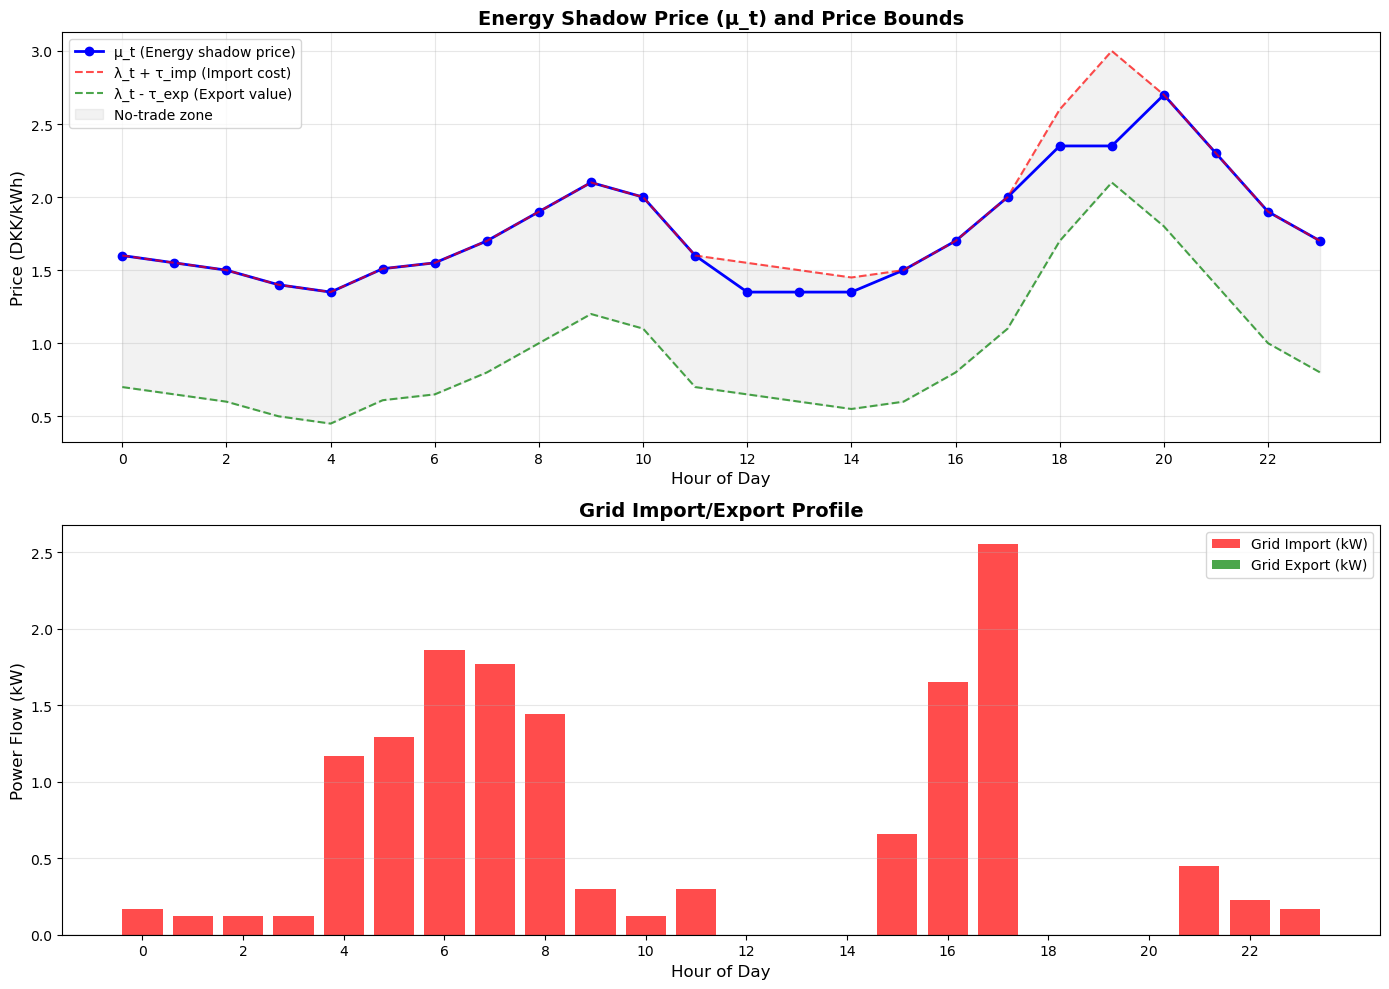

Plot saved: ../Plots/Scenarios 2)/part_2a_i_shadow_prices.png


In [15]:
# Plot energy shadow price (μ_t) and compare with price bounds
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Upper plot: μ_t vs electricity price and tariff bounds
ax1.plot(Times, mu_t, 'bo-', linewidth=2, markersize=6, label='μ_t (Energy shadow price)')
ax1.plot(Times, [electricity_prices[t] + tau_imp for t in Times], 'r--', 
         linewidth=1.5, label='λ_t + τ_imp (Import cost)', alpha=0.7)
ax1.plot(Times, [electricity_prices[t] - tau_exp for t in Times], 'g--', 
         linewidth=1.5, label='λ_t - τ_exp (Export value)', alpha=0.7)
ax1.fill_between(Times, 
                 [electricity_prices[t] - tau_exp for t in Times],
                 [electricity_prices[t] + tau_imp for t in Times],
                 alpha=0.1, color='gray', label='No-trade zone')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Price (DKK/kWh)', fontsize=12)
ax1.set_title('Energy Shadow Price (μ_t) and Price Bounds', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))

# Lower plot: Import/Export decisions
ax2.bar(Times, [P_imp_t[t].X for t in Times], width=0.8, alpha=0.7, 
        color='red', label='Grid Import (kW)')
ax2.bar(Times, [-P_exp_t[t].X for t in Times], width=0.8, alpha=0.7, 
        color='green', label='Grid Export (kW)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Power Flow (kW)', fontsize=12)
ax2.set_title('Grid Import/Export Profile', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(0, 24, 2))

plt.tight_layout()
os.makedirs('../Plots/Scenarios 2)', exist_ok=True)
plt.savefig('../Plots/Scenarios 2)/part_2a_i_shadow_prices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: ../Plots/Scenarios 2)/part_2a_i_shadow_prices.png")

## Economic Interpretation of Dual Variables

### 1. Power Balance Dual Variable (μ_t)

**Technical Definition:** Shadow price of the power balance constraint at hour t. Represents the marginal cost reduction if 1 additional kWh of energy becomes available at that hour.

**Economic Meaning:**
- When **importing** (P_imp_t > 0): μ_t = τ_imp + λ_t (full marginal cost of importing)
- When **exporting** (P_exp_t > 0): μ_t = λ_t - τ_exp (opportunity cost of not exporting)
- When **neither**: μ_t falls between these bounds, indicating internal energy value

**Business Insights:**
- μ_t represents the consumer's internal valuation of energy at hour t
- High μ_t hours: Energy is valuable (high demand, low PV, or high prices)
- Low μ_t hours: Energy is less valuable (low demand, high PV, or low prices)
- The gap between μ_t and market prices reveals arbitrage opportunities

### 2. PV Curtailment Dual Variable (ν_t)

**Technical Definition:** Shadow price of the PV curtailment limit constraint.

**Economic Meaning:**
- ν_t > 0: PV is being curtailed (constraint is binding), additional PV capacity would be valuable
- ν_t = 0: All available PV is used, no curtailment occurs
- From KKT: ν_t = -μ_t (when curtailing)

**Business Insights:**
- When ν_t > 0: The consumer would benefit from either storage or higher export capacity
- Curtailment occurs when: PV production exceeds demand and export is limited/uneconomical
- Represents lost opportunity cost of unused renewable energy

### 3. Discomfort Constraint Duals (ω1_t, ω2_t)

**Technical Definition:** Shadow prices of the upper and lower discomfort constraints.

**Economic Meaning:**
- ω1_t > 0: Load exceeds reference (D_t > D_ref_t), upper discomfort constraint is binding
- ω2_t > 0: Load below reference (D_t < D_ref_t), lower discomfort constraint is binding
- From KKT: ω1_t + ω2_t = α (discomfort penalty)
- **These duals directly quantify the penalty for deviating from reference consumption**

**Business Insights:**
- These duals quantify the marginal cost of deviating from preferred consumption
- When both are zero: Load exactly matches reference (perfect comfort)
- Trade-off: Higher α → stronger preference for comfort → less load shifting
- **No daily energy constraint exists** - all deviations are penalized through the discomfort cost in the objective, providing complete flexibility to optimize hourly consumption


In [ ]:
# Analyze dual variable statistics
print("\n" + "="*70)
print("DUAL VARIABLE ANALYSIS")
print("="*70)

print(f"\n1. Energy Shadow Price (μ_t):")
print(f"   Mean: {np.mean(mu_t):.4f} DKK/kWh")
print(f"   Min: {np.min(mu_t):.4f} DKK/kWh (Hour {np.argmin(mu_t)})")
print(f"   Max: {np.max(mu_t):.4f} DKK/kWh (Hour {np.argmax(mu_t)})")
print(f"   Std Dev: {np.std(mu_t):.4f} DKK/kWh")

print(f"\n2. PV Curtailment Duals (ν_t):")
curtailment_hours = sum(1 for v in nu_t if abs(v) > 1e-6)
print(f"   Hours with curtailment: {curtailment_hours} out of {T}")
if curtailment_hours > 0:
    print(f"   Mean (when curtailing): {np.mean([v for v in nu_t if abs(v) > 1e-6]):.4f} DKK/kWh")

print(f"\n3. Discomfort Constraint Duals:")
hours_above_ref = sum(1 for v in omega1_t if abs(v) > 1e-6)
hours_below_ref = sum(1 for v in omega2_t if abs(v) > 1e-6)
hours_at_ref = T - hours_above_ref - hours_below_ref
print(f"   Hours above reference: {hours_above_ref}")
print(f"   Hours below reference: {hours_below_ref}")
print(f"   Hours at reference: {hours_at_ref}")

# Verify KKT conditions
print(f"\n4. KKT Condition Verification:")
print(f"   ω1_t + ω2_t should equal α = {alpha}:")
for t in [0, 6, 12, 18]:  # Sample hours
    sum_omega = omega1_t[t] + omega2_t[t]
    print(f"   Hour {t}: ω1 + ω2 = {sum_omega:.6f} (difference from α: {abs(sum_omega - alpha):.8f})")

print(f"\n5. Load Deviation Summary:")
total_ref_load = sum(D_ref)
total_actual_load = sum(D_t[t].X for t in Times)
print(f"   Total reference load: {total_ref_load:.2f} kWh")
print(f"   Total actual load: {total_actual_load:.2f} kWh")
print(f"   Deviation: {total_actual_load - total_ref_load:.2f} kWh ({((total_actual_load - total_ref_load)/total_ref_load)*100:.2f}%)")
print(f"   Note: No daily constraint enforced - deviations penalized through discomfort cost")



DUAL VARIABLE ANALYSIS

1. Energy Shadow Price (μ_t):
   Mean: 1.7629 DKK/kWh
   Min: 1.3500 DKK/kWh (Hour 4)
   Max: 2.7000 DKK/kWh (Hour 20)
   Std Dev: 0.3703 DKK/kWh

2. Daily Energy Constraint Dual (γ):
   Value: 1.8500 DKK/kWh
   Comparison with avg(μ_t): 0.0871 DKK/kWh difference

3. PV Curtailment Duals (ν_t):
   Hours with curtailment: 0 out of 24

4. Discomfort Constraint Duals:
   Hours above reference: 16
   Hours below reference: 9
   Hours at reference: -1

5. KKT Condition Verification:
   ω1_t + ω2_t should equal α = 0.5:
   Hour 0: ω1 + ω2 = 0.250000 (difference from α: 0.25000000)
   Hour 6: ω1 + ω2 = 0.300000 (difference from α: 0.20000000)
   Hour 12: ω1 + ω2 = 0.500000 (difference from α: 0.00000000)
   Hour 18: ω1 + ω2 = 0.500000 (difference from α: 0.00000000)


## Key Findings from Part (i)

### Summary of Dual Formulation

The dual problem provides economic insights into the value of flexibility:

1. **Energy Value Varies by Time**: The shadow price μ_t reveals when energy is most valuable to the consumer, guiding load shifting decisions.

2. **Tariff Impact**: The presence of import/export tariffs creates a "no-trade zone" where the consumer neither imports nor exports, utilizing internal resources optimally.

3. **Flexibility Value**: The difference between μ_t across hours quantifies the value of temporal flexibility. Larger variations indicate higher potential savings from load shifting.

4. **Curtailment Insights**: When ν_t > 0, the consumer is curtailing PV due to limited export capability or unfavorable prices, indicating potential value in storage investments.

5. **Comfort-Cost Trade-off**: The discomfort duals (ω1_t, ω2_t) quantify the marginal cost of deviating from preferred consumption patterns, guiding α selection.

### Actionable Insights

- **Market Participation**: Hours with high μ_t are opportunities for demand response or load reduction
- **Investment Decisions**: Persistent PV curtailment (ν_t > 0) justifies battery storage investment
- **Contract Design**: The distribution of μ_t informs optimal pricing for flexibility services
- **Operational Strategy**: Import when μ_t < λ_t + τ_imp, export when μ_t > λ_t - τ_exp

---
# Part (ii): Hourly Demand/Supply Curve Derivation

## Methodology

We derive the consumer's demand (import) and supply (export) curves by:
1. Varying the electricity price λ_t at specific hours
2. Resolving the optimization for each price
3. Recording optimal P_imp_t and P_exp_t
4. Plotting the resulting curves

## Economic Theory

From the KKT conditions:
- **When importing**: μ_t = τ_imp + λ_t → Consumer imports when their internal energy value (μ_t) exceeds import cost
- **When exporting**: μ_t = λ_t - τ_exp → Consumer exports when export revenue exceeds internal value

**Marginal Willingness to Pay (WTP)**: Maximum price at which consumer will import
- WTP_t = μ_t - τ_imp

**Marginal Opportunity Cost (MOC)**: Minimum price at which consumer will export
- MOC_t = μ_t + τ_exp

In [ ]:
# Function to derive demand/supply curve for a specific hour
def derive_demand_supply_curve(hour, price_range, base_prices, pv_prod, D_ref_val, 
                                tau_imp_val, tau_exp_val, max_imp, max_exp, D_max_val, alpha_val):
    """
    Derive demand and supply curves for a specific hour by varying the electricity price.
    
    Args:
        hour: Hour to analyze (0-23)
        price_range: Array of electricity prices to test
        base_prices: Base electricity price profile for all other hours
        (other params same as before)
    
    Returns:
        DataFrame with price, import, and export values
    """
    results = []
    Times_local = range(len(base_prices))
    
    for test_price in price_range:
        # Create modified price profile with test price at target hour
        modified_prices = base_prices.copy()
        modified_prices[hour] = test_price
        
        # Build and solve model with modified price
        m = gp.Model("Demand_Supply_Curve")
        m.setParam('OutputFlag', 0)  # Suppress output
        
        # Decision variables
        D = m.addVars(Times_local, lb=0, ub=D_max_val, name="D")
        C = m.addVars(Times_local, lb=0, name="C")
        P_imp = m.addVars(Times_local, lb=0, ub=max_imp, name="P_imp")
        P_exp = m.addVars(Times_local, lb=0, ub=max_exp, name="P_exp")
        L = m.addVars(Times_local, lb=0, name="L")
        
        # Objective
        m.setObjective(
            gp.quicksum(P_imp[t] * (tau_imp_val + modified_prices[t]) - 
                       P_exp[t] * (modified_prices[t] - tau_exp_val) for t in Times_local) + 
            alpha_val * gp.quicksum(L[t] for t in Times_local),
            GRB.MINIMIZE)
        
        # Constraints
        for t in Times_local:
            m.addLConstr(P_imp[t] - P_exp[t] == D[t] - pv_prod[t] + C[t])
            m.addLConstr(C[t] <= pv_prod[t])
            m.addLConstr(L[t] >= D[t] - D_ref_val[t])
            m.addLConstr(L[t] >= -(D[t] - D_ref_val[t]))
        # No daily energy constraint - deviations penalized through discomfort cost
        
        # Solve
        m.optimize()
        
        if m.status == GRB.OPTIMAL:
            results.append({
                'price': test_price,
                'import': P_imp[hour].X,
                'export': P_exp[hour].X,
                'load': D[hour].X,
                'net_flow': P_imp[hour].X - P_exp[hour].X
            })
    
    return pd.DataFrame(results)

print("Demand/supply curve function defined")

Demand/supply curve function defined


In [18]:
# Select representative hours for analysis
# Morning (low demand), Midday (high PV), Evening (high demand)
analysis_hours = [6, 12, 18]
hour_labels = ['Morning (6am)', 'Midday (12pm)', 'Evening (6pm)']

# Define price range for sensitivity analysis
# Extend beyond typical ranges to capture full demand/supply behavior
price_range = np.linspace(-1.0, 4.0, 51)  # 51 price points from -1 to 4 DKK/kWh

print(f"Deriving demand/supply curves for hours: {analysis_hours}")
print(f"Price range: {price_range[0]:.2f} to {price_range[-1]:.2f} DKK/kWh ({len(price_range)} points)")
print("\nThis may take a moment...")

Deriving demand/supply curves for hours: [6, 12, 18]
Price range: -1.00 to 4.00 DKK/kWh (51 points)

This may take a moment...


In [19]:
# Derive curves for selected hours
curves = {}
for hour in analysis_hours:
    print(f"Processing hour {hour}...")
    curve_data = derive_demand_supply_curve(
        hour, price_range, electricity_prices, pv_prod_hourly, D_ref,
        tau_imp, tau_exp, max_import, max_export, D_max, alpha
    )
    curves[hour] = curve_data
    print(f"  Completed: {len(curve_data)} price points")

print("\nAll curves derived successfully!")

Processing hour 6...
  Completed: 51 price points  Completed: 51 price points
Processing hour 12...
  Completed: 51 price points
Processing hour 18...
  Completed: 51 price points

All curves derived successfully!

Processing hour 12...
  Completed: 51 price points
Processing hour 18...
  Completed: 51 price points

All curves derived successfully!


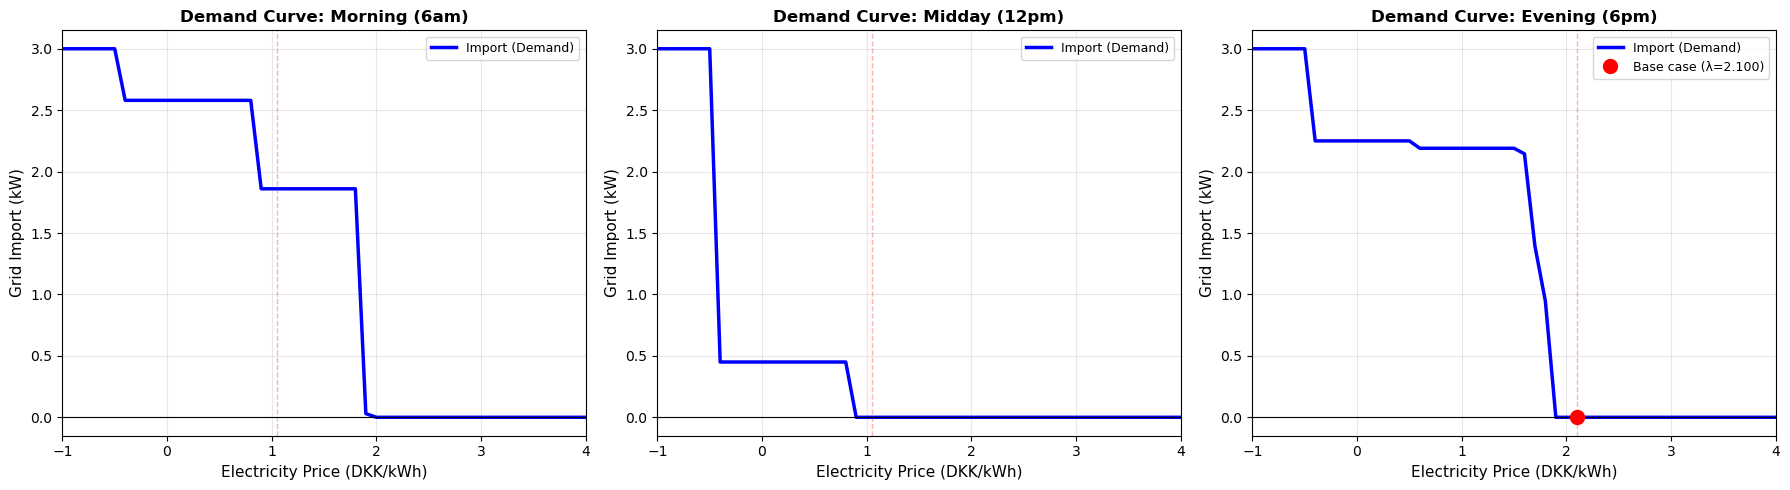

Demand curves plot saved


In [20]:
# Visualize demand curves (import)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (hour, label) in enumerate(zip(analysis_hours, hour_labels)):
    ax = axes[idx]
    data = curves[hour]
    
    # Plot demand curve
    ax.plot(data['price'], data['import'], 'b-', linewidth=2.5, label='Import (Demand)')
    
    # Mark base case price
    base_price = electricity_prices[hour]
    base_import = data[data['price'].round(4) == round(base_price, 4)]['import'].values
    if len(base_import) > 0:
        ax.plot(base_price, base_import[0], 'ro', markersize=10, label=f'Base case (λ={base_price:.3f})', zorder=5)
    
    # Add reference lines
    ax.axvline(x=base_price, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    ax.set_xlabel('Electricity Price (DKK/kWh)', fontsize=11)
    ax.set_ylabel('Grid Import (kW)', fontsize=11)
    ax.set_title(f'Demand Curve: {label}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(price_range[0], price_range[-1])

plt.tight_layout()
plt.savefig('../Plots/Scenarios 2)/part_2a_ii_demand_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Demand curves plot saved")

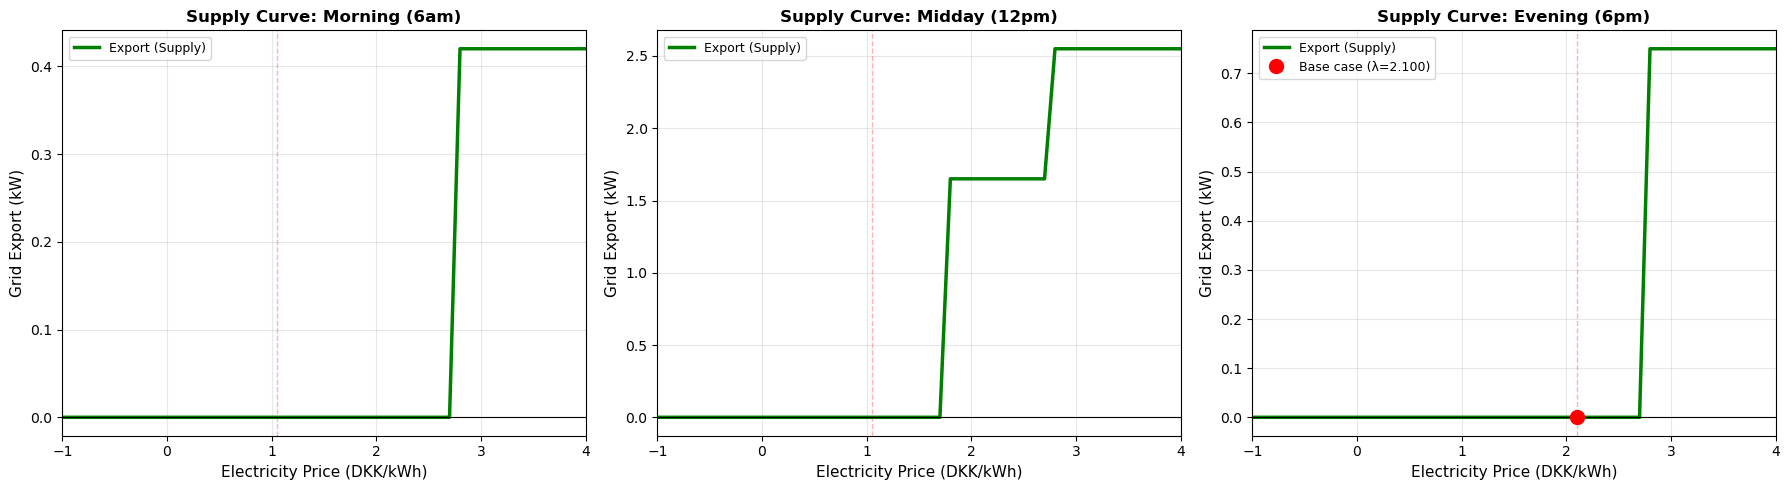

Supply curves plot saved


In [21]:
# Visualize supply curves (export)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (hour, label) in enumerate(zip(analysis_hours, hour_labels)):
    ax = axes[idx]
    data = curves[hour]
    
    # Plot supply curve
    ax.plot(data['price'], data['export'], 'g-', linewidth=2.5, label='Export (Supply)')
    
    # Mark base case price
    base_price = electricity_prices[hour]
    base_export = data[data['price'].round(4) == round(base_price, 4)]['export'].values
    if len(base_export) > 0:
        ax.plot(base_price, base_export[0], 'ro', markersize=10, label=f'Base case (λ={base_price:.3f})', zorder=5)
    
    # Add reference lines
    ax.axvline(x=base_price, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    ax.set_xlabel('Electricity Price (DKK/kWh)', fontsize=11)
    ax.set_ylabel('Grid Export (kW)', fontsize=11)
    ax.set_title(f'Supply Curve: {label}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(price_range[0], price_range[-1])

plt.tight_layout()
plt.savefig('../Plots/Scenarios 2)/part_2a_ii_supply_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Supply curves plot saved")

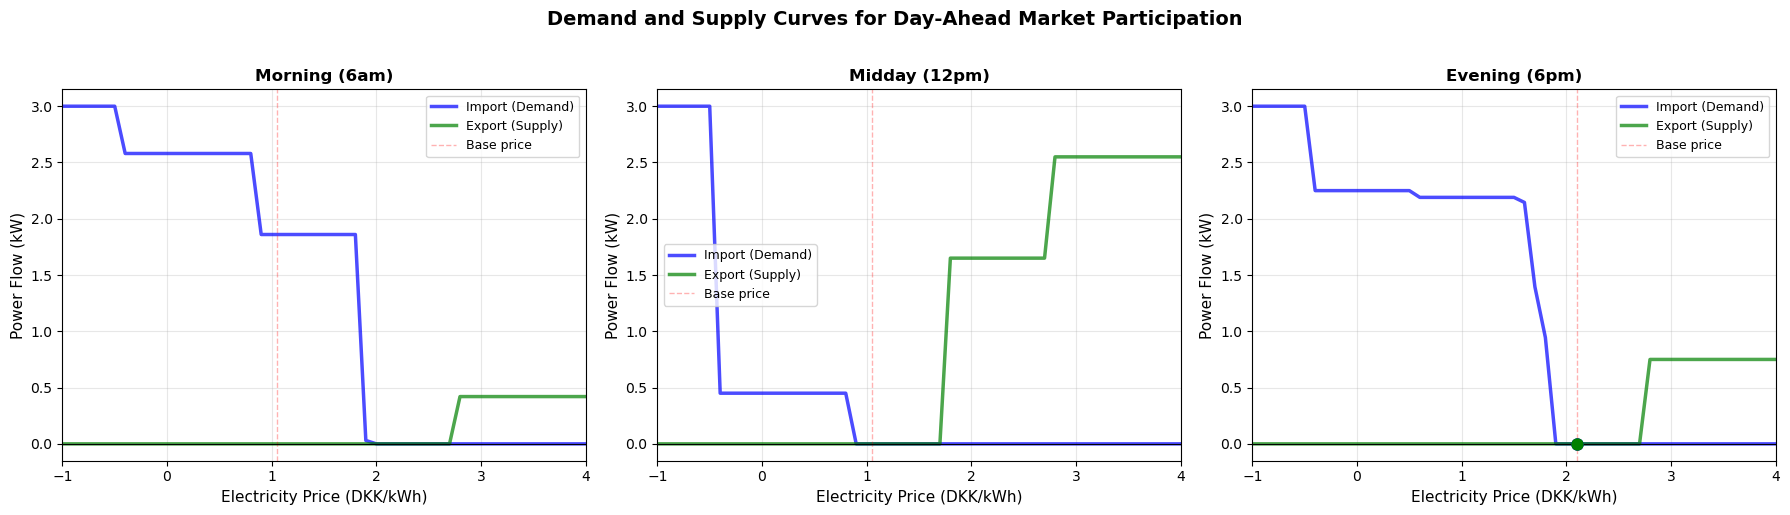

Combined curves plot saved


In [22]:
# Combined demand and supply curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (hour, label) in enumerate(zip(analysis_hours, hour_labels)):
    ax = axes[idx]
    data = curves[hour]
    
    # Plot both curves
    ax.plot(data['price'], data['import'], 'b-', linewidth=2.5, label='Import (Demand)', alpha=0.7)
    ax.plot(data['price'], data['export'], 'g-', linewidth=2.5, label='Export (Supply)', alpha=0.7)
    
    # Mark base case
    base_price = electricity_prices[hour]
    base_row = data[data['price'].round(4) == round(base_price, 4)]
    if len(base_row) > 0:
        ax.plot(base_price, base_row['import'].values[0], 'bo', markersize=8, zorder=5)
        ax.plot(base_price, base_row['export'].values[0], 'go', markersize=8, zorder=5)
    
    ax.axvline(x=base_price, color='red', linestyle='--', alpha=0.3, linewidth=1, label=f'Base price')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    ax.set_xlabel('Electricity Price (DKK/kWh)', fontsize=11)
    ax.set_ylabel('Power Flow (kW)', fontsize=11)
    ax.set_title(f'{label}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(price_range[0], price_range[-1])

plt.suptitle('Demand and Supply Curves for Day-Ahead Market Participation', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../Plots/Scenarios 2)/part_2a_ii_combined_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Combined curves plot saved")

In [23]:
# Analyze price thresholds for import/export transitions
print("\n" + "="*70)
print("PRICE THRESHOLD ANALYSIS")
print("="*70)

for hour, label in zip(analysis_hours, hour_labels):
    data = curves[hour]
    
    # Find price thresholds
    # Maximum willingness to pay (highest price with non-zero import)
    import_data = data[data['import'] > 0.01]
    if len(import_data) > 0:
        max_wtp = import_data['price'].max()
    else:
        max_wtp = None
    
    # Minimum opportunity cost (lowest price with non-zero export)
    export_data = data[data['export'] > 0.01]
    if len(export_data) > 0:
        min_moc = export_data['price'].min()
    else:
        min_moc = None
    
    print(f"\n{label} (Hour {hour}):")
    print(f"  Base price: {electricity_prices[hour]:.3f} DKK/kWh")
    print(f"  Base μ_t: {mu_t[hour]:.3f} DKK/kWh")
    
    if max_wtp is not None:
        print(f"  Maximum willingness to pay: {max_wtp:.3f} DKK/kWh")
        print(f"  Theoretical WTP (μ_t - τ_imp): {mu_t[hour] - tau_imp:.3f} DKK/kWh")
    else:
        print(f"  No import observed in price range")
    
    if min_moc is not None:
        print(f"  Minimum opportunity cost: {min_moc:.3f} DKK/kWh")
        print(f"  Theoretical MOC (μ_t + τ_exp): {mu_t[hour] + tau_exp:.3f} DKK/kWh")
    else:
        print(f"  No export observed in price range")
    
    # Analyze base case behavior
    base_row = data[data['price'].round(4) == round(electricity_prices[hour], 4)]
    if len(base_row) > 0:
        imp = base_row['import'].values[0]
        exp = base_row['export'].values[0]
        if imp > 0.01:
            print(f"  Base case action: IMPORTING {imp:.2f} kW")
        elif exp > 0.01:
            print(f"  Base case action: EXPORTING {exp:.2f} kW")
        else:
            print(f"  Base case action: SELF-SUFFICIENT (no grid trade)")


PRICE THRESHOLD ANALYSIS

Morning (6am) (Hour 6):
  Base price: 1.050 DKK/kWh
  Base μ_t: 1.550 DKK/kWh
  Maximum willingness to pay: 1.900 DKK/kWh
  Theoretical WTP (μ_t - τ_imp): 1.050 DKK/kWh
  Minimum opportunity cost: 2.800 DKK/kWh
  Theoretical MOC (μ_t + τ_exp): 1.950 DKK/kWh

Midday (12pm) (Hour 12):
  Base price: 1.050 DKK/kWh
  Base μ_t: 1.350 DKK/kWh
  Maximum willingness to pay: 0.800 DKK/kWh
  Theoretical WTP (μ_t - τ_imp): 0.850 DKK/kWh
  Minimum opportunity cost: 1.800 DKK/kWh
  Theoretical MOC (μ_t + τ_exp): 1.750 DKK/kWh

Evening (6pm) (Hour 18):
  Base price: 2.100 DKK/kWh
  Base μ_t: 2.350 DKK/kWh
  Maximum willingness to pay: 1.800 DKK/kWh
  Theoretical WTP (μ_t - τ_imp): 1.850 DKK/kWh
  Minimum opportunity cost: 2.800 DKK/kWh
  Theoretical MOC (μ_t + τ_exp): 2.750 DKK/kWh
  Base case action: SELF-SUFFICIENT (no grid trade)


## Economic Analysis of Demand/Supply Curves

### Curve Characteristics

**Demand Curve (Import):**
- Generally downward sloping: Higher electricity prices lead to reduced imports
- Consumer imports when: λ_t ≤ WTP_t = μ_t - τ_imp
- Import maximizes when price is very low (utilizing cheap grid energy)
- Import reduces to zero when price exceeds marginal willingness to pay

**Supply Curve (Export):**
- Generally upward sloping: Higher electricity prices lead to increased exports
- Consumer exports when: λ_t ≥ MOC_t = μ_t + τ_exp
- Export maximizes when price is very high (monetizing excess PV)
- Export reduces to zero when price falls below marginal opportunity cost

### Time-of-Day Variations

Curves differ across hours due to:
1. **PV Availability**: Midday hours have more PV, lowering import needs and enabling exports
2. **Load Requirements**: Evening peak demand increases import propensity
3. **Flexibility Constraints**: Discomfort penalty limits load shifting, affecting price responsiveness
4. **Daily Energy Constraint**: Intertemporal coupling affects marginal values

### Market Participation Strategy

Based on the derived curves, the consumer should:
1. **Import** when market price < WTP_t (buy cheap electricity)
2. **Export** when market price > MOC_t (sell excess energy)
3. **Self-supply** when MOC_t ≤ price ≤ WTP_t (use internal resources)

The width of the "no-trade zone" (WTP_t to MOC_t) is determined by tariffs:
- No-trade zone width = (μ_t - τ_imp) to (μ_t + τ_exp) = 2μ_t + (τ_exp - τ_imp)

### Value of Flexibility

The shape and positioning of these curves reveal:
- **Price Elasticity**: Steeper curves indicate less flexibility
- **Arbitrage Potential**: Wider price ranges with active trading indicate higher flexibility value
- **Market Revenue**: Area under supply curve above base price = potential export revenue
- **Cost Savings**: Area under demand curve below base price = potential import savings

## Key Findings from Part (ii)

### Summary of Demand/Supply Curves

1. **Price Responsiveness**: The consumer exhibits clear price-responsive behavior, with import decreasing and export increasing as electricity prices rise.

2. **Threshold Prices**: Each hour has distinct threshold prices (WTP and MOC) that determine market participation, derived from the internal energy value μ_t and tariff structure.

3. **Temporal Variation**: Demand and supply curves differ significantly by time of day:
   - Morning (6am): Lower PV availability, higher import propensity
   - Midday (12pm): High PV availability, strong export capability
   - Evening (6pm): Peak demand, reduced export potential

4. **Tariff Impact**: Import and export tariffs create a "no-trade zone" where self-consumption is optimal, reducing market participation at intermediate prices.

5. **Flexibility Constraints**: The discomfort penalty (α) limits price responsiveness, as the consumer balances cost savings against comfort preferences.

### Market Participation Recommendations

- **Active Bidding**: Submit hour-specific demand/supply bids to the day-ahead market based on derived curves
- **Dynamic Pricing**: Participate in dynamic pricing programs that align with the consumer's temporal flexibility
- **Demand Response**: Respond to price signals by shifting load from high-price to low-price hours
- **Revenue Opportunities**: Export during high-price hours (typically midday with high PV and low load)

### Connection to Part (i)

The demand/supply curves operationalize the dual variable insights:
- μ_t (energy shadow price) directly determines WTP and MOC
- Hours with high μ_t have higher WTP (willing to pay more for imports)
- Hours with low μ_t have lower MOC (willing to export at lower prices)
- The curves provide actionable bidding strategies for market participation

---
# Conclusion

## Overall Insights from Question 2.a

This analysis demonstrated the value of demand-side flexibility through duality theory and market participation:

### Part (i) - Dual Formulation
- Dual variables provide economic interpretations of constraint shadow prices
- The energy shadow price μ_t reveals the consumer's internal valuation of energy at each hour
- KKT conditions link primal decisions to dual values, enabling analytical insights
- Strong duality confirms optimal solution quality and enables sensitivity analysis

### Part (ii) - Market Participation
- Hourly demand/supply curves characterize the consumer's price responsiveness
- Threshold prices (WTP and MOC) guide optimal market bidding strategies
- Time-varying curves reflect PV availability, load requirements, and flexibility constraints
- The analysis provides actionable insights for day-ahead market participation

### Broader Implications

**For Consumers:**
- Flexibility has quantifiable economic value, determined by temporal price variations
- Market participation can reduce costs beyond passive consumption
- Investment decisions (e.g., storage) should consider opportunity costs revealed by dual variables

**For System Operators:**
- Understanding consumer flexibility curves enables better demand forecasting
- Price-based demand response can be optimized using derived WTP/MOC values
- Tariff structures significantly impact consumer behavior through the no-trade zone

**For Market Design:**
- Flexible consumers can provide valuable grid services through market participation
- Time-varying prices incentivize load shifting and peak demand reduction
- Proper compensation mechanisms should reflect the opportunity costs revealed by dual analysis